# __Author__  : Diba Elahi 
# Autoencoder Reconstruction of Mixed MNIST and CIFAR-10 Images

Importing libraries and modoules I need through exercise

In [124]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

Dataset preparation, MNIST preparation and mean image computation. 

In [125]:
class DuplicateChannels(object):
    def __call__(self, img):
        return img.repeat(3, 1, 1)  

In [126]:
transform_mnist = transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32)), transforms.Normalize((0.5, ), (0.5, )), DuplicateChannels()])

In [127]:
transform_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [128]:
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform_mnist, download=True)

In [129]:
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)

Files already downloaded and verified


In [130]:
min_size = min(len(mnist_dataset), len(cifar_dataset))
mnist_dataset = Subset(mnist_dataset, range(min_size))
cifar_dataset = Subset(cifar_dataset, range(min_size))

In [131]:
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)

In [132]:
cifar_loader = torch.utils.data.DataLoader(cifar_dataset, batch_size=64, shuffle=True)

In [133]:
data_iter = iter(mnist_loader)
images_mnist, labels_mnist = next(data_iter)
print(type(images))
print(images_mnist.shape)
print(labels_mnist.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 32, 32])
torch.Size([64])


In [134]:
data_iter_cifar = iter(cifar_loader)
images_cifar, labels_cifar = next(data_iter_cifar)
print(type(images))
print(images_cifar.shape)
print(labels_cifar.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 32, 32])
torch.Size([64])


In [136]:
class CombinedDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        assert len(self.dataset1) == len(self.dataset2)

    def __len__(self):
        return len(self.dataset1)

    def __getitem__(self, idx):
        img1, label1 = self.dataset1[idx]
        img2, label2 = self.dataset2[idx]
        combined_img = (img1 + img2) / 2
        return combined_img, (label1, label2)


In [137]:
mean_dataset = CombinedDataset(mnist_dataset, cifar_dataset)
mean_loader = DataLoader(mean_dataset, batch_size=64, shuffle=True)

Autoencoder Model Construction

In [138]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # b, 64, 16, 16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # b, 128, 8, 8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # b, 256, 4, 4
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # b, 128, 8, 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # b, 64, 16, 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # b, 3, 32, 32
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Training

In [139]:
autoencoder = Autoencoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [140]:
num_epochs = 10
for epoch in range(num_epochs):
    for images, _ in mean_loader:
        outputs = autoencoder(images)
        loss = loss_function(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

Epoch 1, Loss: 0.0057
Epoch 2, Loss: 0.0028
Epoch 3, Loss: 0.0023
Epoch 4, Loss: 0.0018
Epoch 5, Loss: 0.0014
Epoch 6, Loss: 0.0018
Epoch 7, Loss: 0.0014
Epoch 8, Loss: 0.0016
Epoch 9, Loss: 0.0011
Epoch 10, Loss: 0.0009


Evaluation

In [151]:
mnist_index = random.randint(0, len(mnist_dataset) - 1)
cifar_index = random.randint(0, len(cifar_dataset) - 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


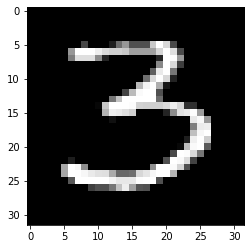

In [152]:
image1, _ = mnist_dataset[mnist_index]
image1_show = image1.numpy().transpose((1, 2, 0))
plt.imshow(image1_show)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


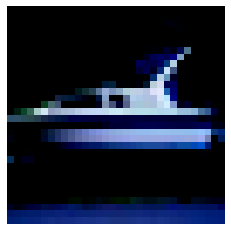

In [153]:
image2, _ = cifar_dataset[cifar_index]
image2_show = image2.numpy().transpose((1, 2, 0))
plt.imshow(image2_show)
plt.axis('off')  # Hide the axes
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


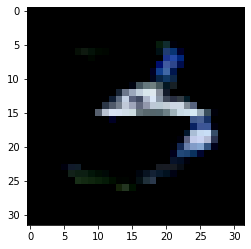

In [154]:
mean_image = (image1 + image2) / 2
mean_image_np = mean_image.numpy().transpose((1, 2, 0))
plt.imshow(mean_image_np)
plt.show()

In [145]:
torch.save(autoencoder.state_dict(), 'autoencoder.pth')
autoencoder.load_state_dict(torch.load('autoencoder.pth'))

<All keys matched successfully>

In [155]:
autoencoder.eval()
with torch.no_grad():
    reconstructed_image = autoencoder(mean_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


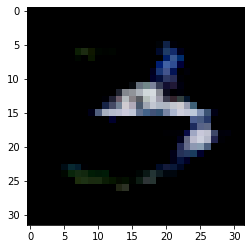

In [156]:
reconstructed_image_show = reconstructed_image.numpy().transpose((1, 2, 0))
plt.imshow(reconstructed_image_show)
plt.show()

In [157]:
mnist_ssim = ssim(image1.squeeze().permute(1, 2, 0).cpu().numpy(), reconstructed_image.squeeze().permute(1, 2, 0).cpu().numpy(), multichannel=True)
cifar_ssim = ssim(image2.squeeze().permute(1, 2, 0).cpu().numpy(), reconstructed_image.squeeze().permute(1, 2, 0).cpu().numpy(), multichannel=True)

mnist_psnr = psnr(image1.squeeze().permute(1, 2, 0).cpu().numpy(), reconstructed_image.squeeze().permute(1, 2, 0).cpu().numpy())
cifar_psnr = psnr(image2.squeeze().permute(1, 2, 0).cpu().numpy(), reconstructed_image.squeeze().permute(1, 2, 0).cpu().numpy())

print(f"MNIST SSIM: {mnist_ssim}, CIFAR-10 SSIM: {cifar_ssim}")
print(f"MNIST PSNR: {mnist_psnr}, CIFAR-10 PSNR: {cifar_psnr}")

MNIST SSIM: 0.42971372604370117, CIFAR-10 SSIM: 0.16572630405426025
MNIST PSNR: 13.044048751245658, CIFAR-10 PSNR: 12.903041612869998


/var/folders/pl/rj51d0nd3px9yj51mmkwv1d40000gn/T/ipykernel_902/3292856353.py:1: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  mnist_ssim = ssim(image1.squeeze().permute(1, 2, 0).cpu().numpy(), reconstructed_image.squeeze().permute(1, 2, 0).cpu().numpy(), multichannel=True)
/var/folders/pl/rj51d0nd3px9yj51mmkwv1d40000gn/T/ipykernel_902/3292856353.py:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  cifar_ssim = ssim(image2.squeeze().permute(1, 2, 0).cpu().numpy(), reconstructed_image.squeeze().permute(1, 2, 0).cpu().numpy(), multichannel=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


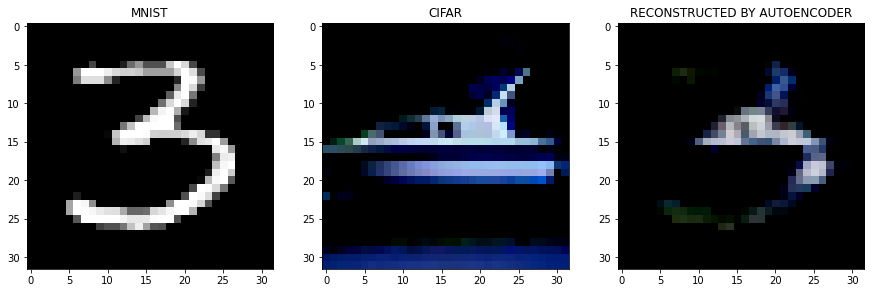

In [158]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(image1.numpy().transpose((1, 2, 0)))
axs[0].set_title('MNIST')

axs[1].imshow(image2.numpy().transpose((1, 2, 0)))
axs[1].set_title('CIFAR')

axs[2].imshow(reconstructed_image.numpy().transpose((1, 2, 0)))
axs[2].set_title('RECONSTRUCTED BY AUTOENCODER')

plt.show()